In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/photos/Lunch-Line.jpg


# 1. Regression Coefficient Tests: Introduction
- Regression helps us understand how different factors influence an outcome.
- In regression, hypothesis testing is used to check if predictors (process factors) really matter.
- Null hypothesis (H₀): coefficient = 0 (predictor has no effect).  
- Alternative hypothesis (H₁): coefficient ≠ 0 (predictor has an effect).



# 2. Regression Coefficient Tests: The Basics
- What coefficient tests measure:
  - Estimate (slope) → size and direction of effect.
  - Standard error → how precise the estimate is.
  - t-statistic → test value.
  - p-value → probability result is due to chance.
- Small p-value: evidence predictor matters.
- Large p-value: no evidence predictor matters.




# 3. Example: Bottleneck Analysis  
- Scenario: A school lunch line where students must go through steps before being served.

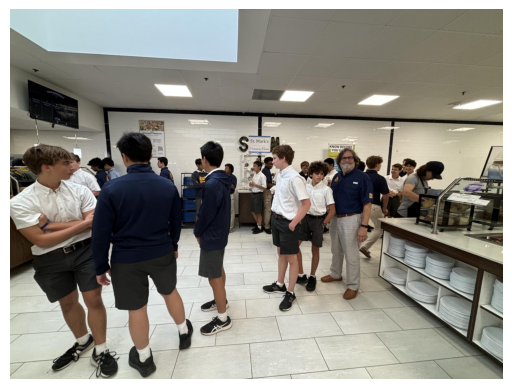

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your uploaded image
img_path = "/kaggle/input/photos/Lunch-Line.jpg"

# Read and display the image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()


Setup of Our Regression Example  

- Steps (predictors):  
  - Order taking time  
  - Cooking time  
  - Packaging time  
  - Tray color 

- Outcome (response):  
  - Total customer wait time  

> We include tray color on purpose as a "dummy" predictor.
> By adding tray color into the model, we can demonstrate how regression and hypothesis testing identify **useful predictors** versus **useless predictors**.



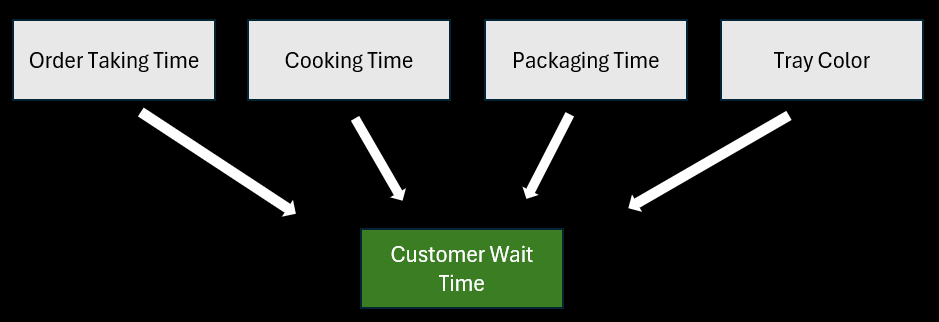

- Question: Which step contributes most to overall delays?

# 4. Simulated Dataset
- Generate synthetic data:
  - `WaitTime` = response.
  - Predictors: `OrderTime`, `CookTime`, `PackTime`.
- Make `CookTime` the bottleneck in simulation (longest, most variable).
- Show the dataset preview.

In [4]:
import numpy as np
import pandas as pd

# For reproducibility
np.random.seed(42)

# Number of samples
n = 500

# Simulate predictors
OrderTime = np.random.normal(loc=6, scale=0.5, size=n)     # order taking ~1 min
CookTime  = np.random.normal(loc=6, scale=2.0, size=n)     # cooking ~6 min (bottleneck, longest + more variable)
PackTime  = np.random.normal(loc=6, scale=0.7, size=n)     # packaging ~2 min

# Ensure no negatives
OrderTime = np.clip(OrderTime, 0.5, None)
CookTime  = np.clip(CookTime, 2.0, None)
PackTime  = np.clip(PackTime, 0.7, None)

# Response variable: WaitTime is mostly driven by CookTime
# Add some noise to reflect real-world variability
noise = np.random.normal(loc=0, scale=1, size=n)
WaitTime = OrderTime + CookTime + PackTime + noise

# Add a dummy factor: TrayColor
# 0 = Grey tray, 1 = Blue tray
TrayColor = np.random.randint(0, 2, size=n)

# Create DataFrame
df = pd.DataFrame({
    "OrderTime": OrderTime,
    "CookTime": CookTime,
    "PackTime": PackTime,
    "TrayColor": TrayColor,
    "WaitTime": WaitTime
}).round(1)

# Preview dataset
print(df.head())


   OrderTime  CookTime  PackTime  TrayColor  WaitTime
0        6.2       7.9       7.0          1      21.9
1        5.9       9.8       6.6          0      21.8
2        6.3       3.2       6.0          1      14.8
3        6.8       7.1       5.5          0      19.4
4        5.9       4.7       6.5          0      16.9


# 5. Exploratory Data Analysis

Before interpreting the regression results, it is useful to explore how the predictors relate to each other and to the response variable. A correlation matrix gives a quick overview of these relationships. Strong positive correlations suggest that a predictor moves closely with wait time, while weak or near-zero correlations indicate little to no relationship.

The heatmap below shows the pairwise correlations between OrderTime, CookTime, PackTime, TrayColor, and WaitTime. This helps us confirm that the meaningful predictors (time-based steps) are strongly correlated with wait time, while irrelevant predictors such as tray color are not.

To complement this, we also visualize:
- Regression coefficients as a bar chart, showing the relative contribution of each predictor in the fitted model.
- A scatterplot matrix, highlighting how the bottleneck step (cooking) drives overall waiting time.
- 3D scatterplot using OrderTime, CookTime, PackTime under a heat gradient to show waiting times.

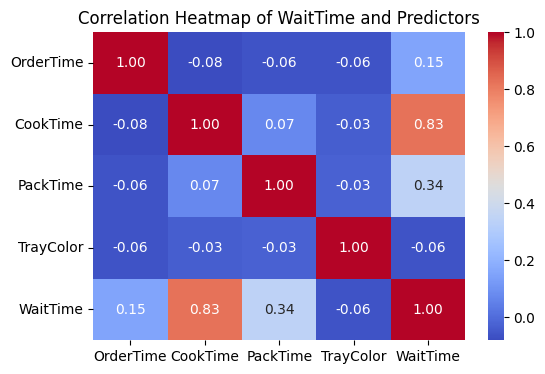

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[["OrderTime", "CookTime", "PackTime", "TrayColor", "WaitTime"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of WaitTime and Predictors")
plt.show()


### Correlation Heatmap
This chart shows how strongly each variable is related to the others. Darker red means a stronger positive relationship, while blue means little or no relationship. We can see that CookTime and PackTime are strongly related to WaitTime, while TrayColor shows almost no relationship.



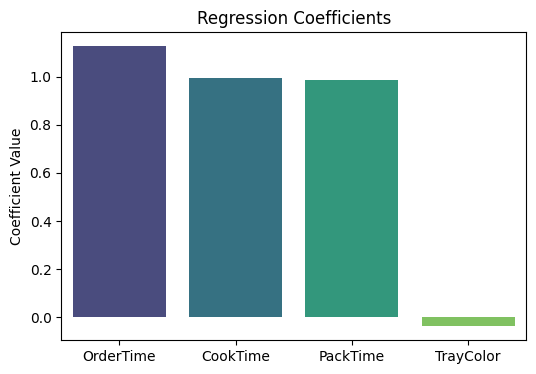

In [12]:
# Bar chart of regression coefficients
coef = model.params.drop("const")
plt.figure(figsize=(6,4))
sns.barplot(x=coef.index, y=coef.values, palette="viridis")
plt.title("Regression Coefficients")
plt.ylabel("Coefficient Value")
plt.show()



### Regression Coefficients
This bar chart shows the contribution of each variable in the regression model. OrderTime, CookTime, and PackTime all have large positive effects on WaitTime. TrayColor has a near-zero effect, confirming it is not important.

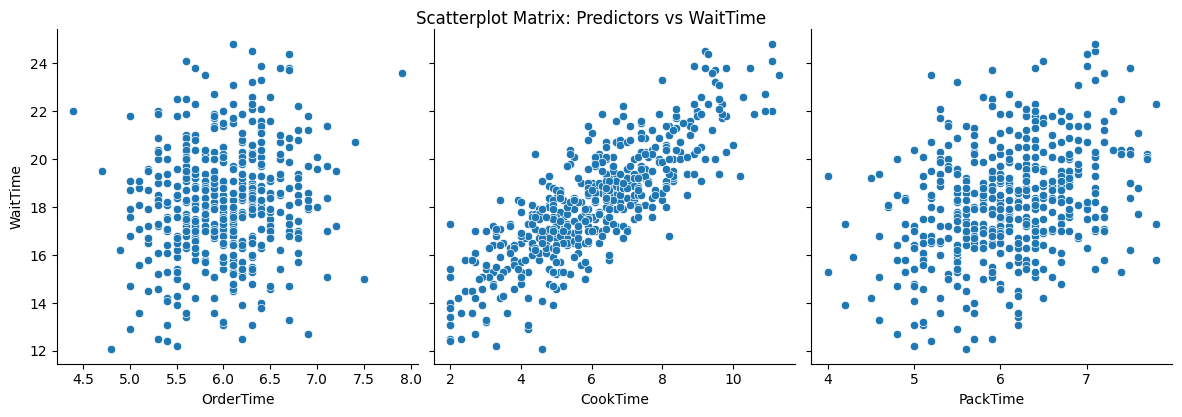

In [8]:
# Scatterplot matrix (only numeric predictors vs WaitTime)
sns.pairplot(df, x_vars=["OrderTime", "CookTime", "PackTime"],
             y_vars="WaitTime", height=4, aspect=1, kind="scatter")
plt.suptitle("Scatterplot Matrix: Predictors vs WaitTime", y=1.02)
plt.show()

### Scatterplot Matrix
These scatterplots compare each predictor with WaitTime. CookTime has a clear upward trend, showing it is the biggest driver of wait times. OrderTime and PackTime also add to WaitTime but with more spread. This helps visualize which steps in the process matter most.



In [7]:
import numpy as np
import pandas as pd
import plotly.express as px

# For reproducibility
np.random.seed(42)

# Number of samples
n = 500

# Simulate predictors
OrderTime = np.random.normal(loc=6, scale=0.5, size=n)
CookTime  = np.random.normal(loc=6, scale=2.0, size=n)
PackTime  = np.random.normal(loc=6, scale=0.7, size=n)

# Ensure no negatives
OrderTime = np.clip(OrderTime, 0.5, None)
CookTime  = np.clip(CookTime, 2.0, None)
PackTime  = np.clip(PackTime, 0.7, None)

# Response variable: WaitTime
noise = np.random.normal(loc=0, scale=1, size=n)
WaitTime = OrderTime + CookTime + PackTime + noise

# DataFrame
df = pd.DataFrame({
    "OrderTime": OrderTime,
    "CookTime": CookTime,
    "PackTime": PackTime,
    "WaitTime": WaitTime
}).round(1)

# Interactive 3D scatter with Plotly
fig = px.scatter_3d(
    df,
    x="OrderTime",
    y="CookTime",
    z="PackTime",
    color="WaitTime",
    color_continuous_scale="hot",
    opacity=0.7,
    title="Interactive 3D Scatterplot of Predictors Colored by WaitTime"
)

fig.update_traces(marker=dict(size=4))  # adjust point size
fig.show()


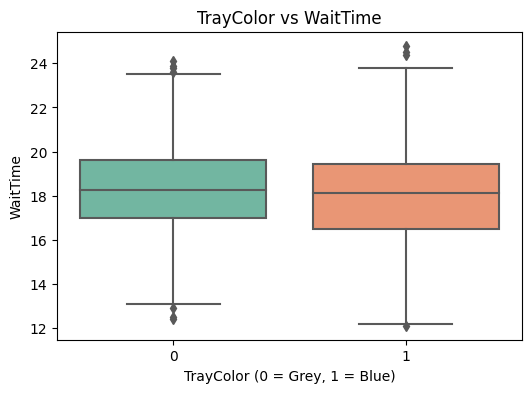

In [9]:
# Boxplot: TrayColor vs WaitTime (better than scatter for categorical variable)
plt.figure(figsize=(6,4))
sns.boxplot(x="TrayColor", y="WaitTime", data=df, palette="Set2")
plt.title("TrayColor vs WaitTime")
plt.xlabel("TrayColor (0 = Grey, 1 = Blue)")
plt.ylabel("WaitTime")
plt.show()




### TrayColor vs WaitTime
This boxplot compares wait times for students with grey trays versus blue trays. The two groups look almost the same, showing that tray color has no real impact on how long students wait. This illustrates what a useless variable looks like in practice.

# 6. Regression Model
- Fit multiple linear regression (`WaitTime ~ OrderTime + CookTime + PackTime`).
- Show regression output (coefficients, t-stats, p-values, R²).

In [5]:
import statsmodels.api as sm

# Define predictors (including TrayColor)
X = df[["OrderTime", "CookTime", "PackTime", "TrayColor"]]
y = df["WaitTime"]

# Add intercept (constant term)
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               WaitTime   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     569.4
Date:                Thu, 11 Sep 2025   Prob (F-statistic):          1.27e-183
Time:                        17:32:20   Log-Likelihood:                -699.98
No. Observations:                 500   AIC:                             1410.
Df Residuals:                     495   BIC:                             1431.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5689      0.705     -0.807      0.4

### Interpretation of the Model

The regression model explains about 82.5% of the variation in total wait time (R-squared = 0.825). This indicates a strong fit to the data.

Looking at the coefficients:
- OrderTime, CookTime, and PackTime all have coefficients close to 1, with very small p-values (< 0.001). This means each of these steps significantly contributes to the total wait time, which matches our expectations since the response variable was generated as their sum.
- TrayColor has a coefficient close to 0 (−0.0318) and a very high p-value (0.720). This shows that tray color has no meaningful impact on wait time.

The intercept (const) is also not significant, which is expected because the simulated data does not include a baseline offset.

Conclusion: The three process steps (order taking, cooking, packaging) are statistically significant contributors to wait time. Tray color is not significant, confirming it is a useless variable in this model. This illustrates how hypothesis testing helps distinguish meaningful predictors from irrelevant ones.


# 7. Conclusion

This example illustrates how regression analysis can be used to identify which factors significantly affect an outcome while filtering out irrelevant ones. In the lunch line case, regression helped reveal the bottleneck step driving overall wait times.

The key takeaway is that regression is not just about fitting lines to data—it is a powerful inferential tool that can guide real-world decision-making. By examining coefficients, test statistics, and p-values, we can distinguish between meaningful and meaningless predictors.

This same method can be extrapolated to far more complex datasets, such as:
- Predicting production throughput in manufacturing lines
- Understanding patient wait times in healthcare operations
- Analyzing delivery performance in logistics networks
- Estimating energy consumption in buildings
- Measuring the drivers of student performance in education

In each case, regression provides a structured way to test hypotheses, quantify effects, and make data-driven improvements.
